# Data Preprocessing

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from Bio import SeqIO
from copy import deepcopy

# Set device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using device: {device}")

Using device: cuda


### Load tensors from precomputed ESM embeddings folders

In [2]:
def load_tensors_from_directory(directory):
    tensors = []
    try:
        for filename in tqdm(os.listdir(directory), desc=f"Loading {directory}"):
            file_path = os.path.join(directory, filename)
            if os.path.isfile(file_path):
                tensor = torch.load(file_path, weights_only=True)
                tensors.append(tensor)
        return torch.stack(tensors)
    except Exception as e:
        print(f"Error reading directory {directory}: {e}")
        return None

# Stack into tensors
positive_embeddings = load_tensors_from_directory('positive_protein_embeddings')
negative_embeddings = load_tensors_from_directory('negative_protein_embeddings')


Loading negative_protein_embeddings: 100%|██████████| 6677/6677 [00:13<00:00, 488.15it/s]


### Create Labeled Dataset

In [3]:
# Create labels
positive_labels = torch.ones(len(positive_embeddings))
negative_labels = torch.zeros(len(negative_embeddings))

# Combine embeddings with labels
all_embeddings = torch.cat([positive_embeddings, negative_embeddings], dim=0)
all_labels = torch.cat([positive_labels, negative_labels], dim=0)

print(f"\nCombined embeddings shape: {all_embeddings.shape}")
print(f"Combined labels shape: {all_labels.shape}")


Combined embeddings shape: torch.Size([13624, 3072])
Combined labels shape: torch.Size([13624])


### Create a 70/15/15 Train/Dev/Test split

In [4]:
# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    all_embeddings,
    all_labels,
    test_size=0.3,
    random_state=42,
    stratify=all_labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

# Move to device and ensure correct dtype
X_train = X_train.float().to(device)
X_val = X_val.float().to(device)
X_test = X_test.float().to(device)
y_train = y_train.long().to(device)
y_val = y_val.long().to(device)
y_test = y_test.long().to(device)

# Print shapes and class distributions
print("\nData split summary:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"  Positive: {torch.sum(y_train == 1)} ({torch.sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"  Negative: {torch.sum(y_train == 0)} ({torch.sum(y_train == 0)/len(y_train)*100:.1f}%)")

print(f"\nValidation set: {X_val.shape[0]} samples")
print(f"  Positive: {torch.sum(y_val == 1)} ({torch.sum(y_val == 1)/len(y_val)*100:.1f}%)")
print(f"  Negative: {torch.sum(y_val == 0)} ({torch.sum(y_val == 0)/len(y_val)*100:.1f}%)")

print(f"\nTest set: {X_test.shape[0]} samples")
print(f"  Positive: {torch.sum(y_test == 1)} ({torch.sum(y_test == 1)/len(y_test)*100:.1f}%)")
print(f"  Negative: {torch.sum(y_test == 0)} ({torch.sum(y_test == 0)/len(y_test)*100:.1f}%)")

# Create DataLoader with float labels
train_dataset = torch.utils.data.TensorDataset(X_train, y_train.float())
val_dataset = torch.utils.data.TensorDataset(X_val, y_val.float())
test_dataset = torch.utils.data.TensorDataset(X_test, y_test.float())

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Data split summary:
Training set: 9536 samples
  Positive: 4862 (51.0%)
  Negative: 4674 (49.0%)

Validation set: 2044 samples
  Positive: 1043 (51.0%)
  Negative: 1001 (49.0%)

Test set: 2044 samples
  Positive: 1042 (51.0%)
  Negative: 1002 (49.0%)


# Test Simple Neural Network for Binary Classification

In [5]:
class ProteinClassifier(nn.Module):
    def __init__(self, input_dim=3072, hidden_dim=1024):
        super().__init__()
        # Larger network with batch normalization
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(hidden_dim // 4, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x).squeeze()

# Initialize model, loss function, and optimizer
model = ProteinClassifier().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# Training function with gradient clipping to avoid exploding graidents
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []
    
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Normalize inputs
        inputs = (inputs - inputs.mean(dim=1, keepdim=True)) / (inputs.std(dim=1, keepdim=True) + 1e-8)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        predictions.extend((outputs > 0.5).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    
    return total_loss / len(train_loader), predictions, true_labels

# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Normalize inputs
            inputs = (inputs - inputs.mean(dim=1, keepdim=True)) / (inputs.std(dim=1, keepdim=True) + 1e-8)
            outputs = model(inputs)
            predictions.extend((outputs > 0.5).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return {
        'accuracy': accuracy_score(true_labels, predictions),
        'precision': precision_score(true_labels, predictions, zero_division=0),
        'recall': recall_score(true_labels, predictions, zero_division=0),
        'f1': f1_score(true_labels, predictions, zero_division=0)
    }

# Training loop
n_epochs = 30
train_losses = []
val_metrics = []

for epoch in range(n_epochs):
    # Train
    loss, train_preds, train_labels = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(loss)
    
    # Evaluate
    train_metrics = evaluate(model, train_loader)
    val_metrics_epoch = evaluate(model, val_loader)
    val_metrics.append(val_metrics_epoch)
    
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    print(f"Train Loss: {loss:.4f}")
    print(f"Train Metrics: Accuracy={train_metrics['accuracy']:.4f}, F1={train_metrics['f1']:.4f}")
    print(f"Val Metrics: Accuracy={val_metrics_epoch['accuracy']:.4f}, F1={val_metrics_epoch['f1']:.4f}")

# Final evaluation on test set
test_metrics = evaluate(model, test_loader)
print("\nFinal Test Set Metrics:")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")

Training: 100%|██████████| 149/149 [00:01<00:00, 145.11it/s]



Epoch 1/30
Train Loss: 0.4938
Train Metrics: Accuracy=0.7999, F1=0.7991
Val Metrics: Accuracy=0.7652, F1=0.7605


Training: 100%|██████████| 149/149 [00:00<00:00, 192.33it/s]



Epoch 2/30
Train Loss: 0.4098
Train Metrics: Accuracy=0.8498, F1=0.8639
Val Metrics: Accuracy=0.8141, F1=0.8326


Training: 100%|██████████| 149/149 [00:00<00:00, 194.73it/s]



Epoch 3/30
Train Loss: 0.3641
Train Metrics: Accuracy=0.8837, F1=0.8885
Val Metrics: Accuracy=0.8141, F1=0.8221


Training: 100%|██████████| 149/149 [00:00<00:00, 195.53it/s]



Epoch 4/30
Train Loss: 0.3167
Train Metrics: Accuracy=0.9021, F1=0.9067
Val Metrics: Accuracy=0.8351, F1=0.8448


Training: 100%|██████████| 149/149 [00:00<00:00, 192.66it/s]



Epoch 5/30
Train Loss: 0.2922
Train Metrics: Accuracy=0.9165, F1=0.9192
Val Metrics: Accuracy=0.8297, F1=0.8358


Training: 100%|██████████| 149/149 [00:00<00:00, 196.68it/s]



Epoch 6/30
Train Loss: 0.2493
Train Metrics: Accuracy=0.9399, F1=0.9421
Val Metrics: Accuracy=0.8415, F1=0.8490


Training: 100%|██████████| 149/149 [00:00<00:00, 196.13it/s]



Epoch 7/30
Train Loss: 0.2254
Train Metrics: Accuracy=0.9232, F1=0.9260
Val Metrics: Accuracy=0.8293, F1=0.8371


Training: 100%|██████████| 149/149 [00:00<00:00, 197.79it/s]



Epoch 8/30
Train Loss: 0.2076
Train Metrics: Accuracy=0.9583, F1=0.9595
Val Metrics: Accuracy=0.8430, F1=0.8481


Training: 100%|██████████| 149/149 [00:00<00:00, 196.62it/s]



Epoch 9/30
Train Loss: 0.1759
Train Metrics: Accuracy=0.9650, F1=0.9663
Val Metrics: Accuracy=0.8562, F1=0.8645


Training: 100%|██████████| 149/149 [00:00<00:00, 194.77it/s]



Epoch 10/30
Train Loss: 0.1668
Train Metrics: Accuracy=0.9706, F1=0.9710
Val Metrics: Accuracy=0.8537, F1=0.8548


Training: 100%|██████████| 149/149 [00:00<00:00, 194.90it/s]



Epoch 11/30
Train Loss: 0.1478
Train Metrics: Accuracy=0.9742, F1=0.9750
Val Metrics: Accuracy=0.8591, F1=0.8674


Training: 100%|██████████| 149/149 [00:00<00:00, 195.03it/s]



Epoch 12/30
Train Loss: 0.1314
Train Metrics: Accuracy=0.9797, F1=0.9800
Val Metrics: Accuracy=0.8586, F1=0.8602


Training: 100%|██████████| 149/149 [00:00<00:00, 195.09it/s]



Epoch 13/30
Train Loss: 0.1264
Train Metrics: Accuracy=0.9790, F1=0.9794
Val Metrics: Accuracy=0.8488, F1=0.8518


Training: 100%|██████████| 149/149 [00:00<00:00, 197.75it/s]



Epoch 14/30
Train Loss: 0.1169
Train Metrics: Accuracy=0.9773, F1=0.9779
Val Metrics: Accuracy=0.8547, F1=0.8601


Training: 100%|██████████| 149/149 [00:00<00:00, 192.24it/s]



Epoch 15/30
Train Loss: 0.1061
Train Metrics: Accuracy=0.9858, F1=0.9862
Val Metrics: Accuracy=0.8586, F1=0.8621


Training: 100%|██████████| 149/149 [00:00<00:00, 196.89it/s]



Epoch 16/30
Train Loss: 0.0952
Train Metrics: Accuracy=0.9880, F1=0.9883
Val Metrics: Accuracy=0.8532, F1=0.8559


Training: 100%|██████████| 149/149 [00:00<00:00, 197.05it/s]



Epoch 17/30
Train Loss: 0.0990
Train Metrics: Accuracy=0.9875, F1=0.9877
Val Metrics: Accuracy=0.8537, F1=0.8542


Training: 100%|██████████| 149/149 [00:00<00:00, 214.99it/s]



Epoch 18/30
Train Loss: 0.0864
Train Metrics: Accuracy=0.9863, F1=0.9864
Val Metrics: Accuracy=0.8513, F1=0.8516


Training: 100%|██████████| 149/149 [00:00<00:00, 210.17it/s]



Epoch 19/30
Train Loss: 0.0845
Train Metrics: Accuracy=0.9842, F1=0.9845
Val Metrics: Accuracy=0.8542, F1=0.8574


Training: 100%|██████████| 149/149 [00:00<00:00, 215.25it/s]



Epoch 20/30
Train Loss: 0.0798
Train Metrics: Accuracy=0.9868, F1=0.9870
Val Metrics: Accuracy=0.8537, F1=0.8552


Training: 100%|██████████| 149/149 [00:00<00:00, 214.37it/s]



Epoch 21/30
Train Loss: 0.0776
Train Metrics: Accuracy=0.9939, F1=0.9940
Val Metrics: Accuracy=0.8601, F1=0.8621


Training: 100%|██████████| 149/149 [00:00<00:00, 216.65it/s]



Epoch 22/30
Train Loss: 0.0707
Train Metrics: Accuracy=0.9926, F1=0.9927
Val Metrics: Accuracy=0.8552, F1=0.8608


Training: 100%|██████████| 149/149 [00:00<00:00, 212.43it/s]



Epoch 23/30
Train Loss: 0.0660
Train Metrics: Accuracy=0.9934, F1=0.9935
Val Metrics: Accuracy=0.8650, F1=0.8709


Training: 100%|██████████| 149/149 [00:00<00:00, 211.58it/s]



Epoch 24/30
Train Loss: 0.0656
Train Metrics: Accuracy=0.9933, F1=0.9934
Val Metrics: Accuracy=0.8630, F1=0.8639


Training: 100%|██████████| 149/149 [00:00<00:00, 212.04it/s]



Epoch 25/30
Train Loss: 0.0667
Train Metrics: Accuracy=0.9941, F1=0.9942
Val Metrics: Accuracy=0.8581, F1=0.8610


Training: 100%|██████████| 149/149 [00:00<00:00, 211.75it/s]



Epoch 26/30
Train Loss: 0.0610
Train Metrics: Accuracy=0.9950, F1=0.9951
Val Metrics: Accuracy=0.8679, F1=0.8723


Training: 100%|██████████| 149/149 [00:00<00:00, 216.09it/s]



Epoch 27/30
Train Loss: 0.0566
Train Metrics: Accuracy=0.9939, F1=0.9940
Val Metrics: Accuracy=0.8537, F1=0.8529


Training: 100%|██████████| 149/149 [00:00<00:00, 213.45it/s]



Epoch 28/30
Train Loss: 0.0601
Train Metrics: Accuracy=0.9938, F1=0.9939
Val Metrics: Accuracy=0.8615, F1=0.8639


Training: 100%|██████████| 149/149 [00:00<00:00, 214.29it/s]



Epoch 29/30
Train Loss: 0.0519
Train Metrics: Accuracy=0.9953, F1=0.9954
Val Metrics: Accuracy=0.8596, F1=0.8586


Training: 100%|██████████| 149/149 [00:00<00:00, 213.72it/s]



Epoch 30/30
Train Loss: 0.0479
Train Metrics: Accuracy=0.9960, F1=0.9961
Val Metrics: Accuracy=0.8576, F1=0.8562

Final Test Set Metrics:
Accuracy: 0.8434
Precision: 0.8676
Recall: 0.8177
F1 Score: 0.8419


### Plot Traning Curves

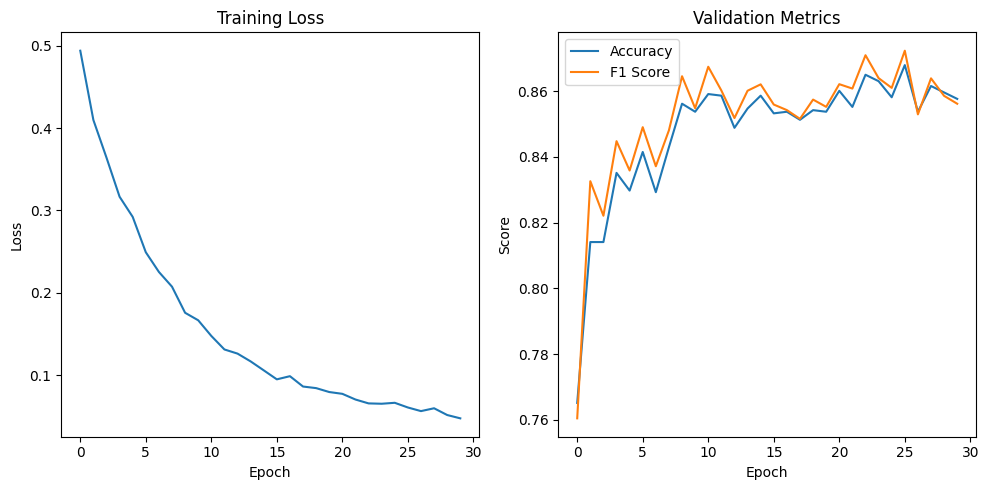

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot([m['accuracy'] for m in val_metrics], label='Accuracy')
plt.plot([m['f1'] for m in val_metrics], label='F1 Score')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

# Training Suite to compare Neural Network Models with different parameters


Training Logistic Regression...



Epoch 5/50
Train Loss: 0.4874
Train Metrics: Accuracy=0.7634, F1=0.7720
Val Metrics: Accuracy=0.7559, F1=0.7636



Epoch 10/50
Train Loss: 0.4618
Train Metrics: Accuracy=0.7771, F1=0.7899
Val Metrics: Accuracy=0.7735, F1=0.7873



Epoch 15/50
Train Loss: 0.4466
Train Metrics: Accuracy=0.7857, F1=0.7921
Val Metrics: Accuracy=0.7794, F1=0.7874



Epoch 20/50
Train Loss: 0.4386
Train Metrics: Accuracy=0.7938, F1=0.8102
Val Metrics: Accuracy=0.7798, F1=0.7984



Epoch 25/50
Train Loss: 0.4294
Train Metrics: Accuracy=0.8002, F1=0.8092
Val Metrics: Accuracy=0.7877, F1=0.7974



Epoch 30/50
Train Loss: 0.4275
Train Metrics: Accuracy=0.7978, F1=0.7969
Val Metrics: Accuracy=0.7891, F1=0.7890



Epoch 35/50
Train Loss: 0.4169
Train Metrics: Accuracy=0.8049, F1=0.8232
Val Metrics: Accuracy=0.7891, F1=0.8104



Epoch 40/50
Train Loss: 0.4079
Train Metrics: Accuracy=0.8147, F1=0.8254
Val Metrics: Accuracy=0.7955, F1=0.8079



Epoch 45/50
Train Loss: 0.4056
Train Metrics: Accuracy=0.8167, F1=0.8280
Val Metrics: Accuracy=0.7975, F1=0.8104



Epoch 50/50
Train Loss: 0.3996
Train Metrics: Accuracy=0.8199, F1=0.8347
Val Metrics: Accuracy=0.8014, F1=0.8183

Logistic Regression Final Test Metrics:
Accuracy: 0.7901
Precision: 0.7672
Recall: 0.8445
F1 Score: 0.8040

Training Simple Model...



Epoch 5/50
Train Loss: 0.3237
Train Metrics: Accuracy=0.8691, F1=0.8670
Val Metrics: Accuracy=0.8058, F1=0.8038



Epoch 10/50
Train Loss: 0.2163
Train Metrics: Accuracy=0.9389, F1=0.9404
Val Metrics: Accuracy=0.8493, F1=0.8542



Epoch 15/50
Train Loss: 0.1443
Train Metrics: Accuracy=0.9632, F1=0.9647
Val Metrics: Accuracy=0.8567, F1=0.8645



Epoch 20/50
Train Loss: 0.0973
Train Metrics: Accuracy=0.9865, F1=0.9868
Val Metrics: Accuracy=0.8591, F1=0.8640



Epoch 25/50
Train Loss: 0.0729
Train Metrics: Accuracy=0.9921, F1=0.9923
Val Metrics: Accuracy=0.8659, F1=0.8695



Epoch 30/50
Train Loss: 0.0478
Train Metrics: Accuracy=0.9980, F1=0.9980
Val Metrics: Accuracy=0.8615, F1=0.8634



Epoch 35/50
Train Loss: 0.0389
Train Metrics: Accuracy=0.9954, F1=0.9955
Val Metrics: Accuracy=0.8469, F1=0.8412



Epoch 40/50
Train Loss: 0.0415
Train Metrics: Accuracy=0.9851, F1=0.9852
Val Metrics: Accuracy=0.8444, F1=0.8415



Epoch 45/50
Train Loss: 0.0364
Train Metrics: Accuracy=0.9975, F1=0.9975
Val Metrics: Accuracy=0.8625, F1=0.8647



Epoch 50/50
Train Loss: 0.0231
Train Metrics: Accuracy=0.9991, F1=0.9991
Val Metrics: Accuracy=0.8718, F1=0.8744

Simple Model Final Test Metrics:
Accuracy: 0.8542
Precision: 0.8407
Recall: 0.8810
F1 Score: 0.8604

Training Medium Model...



Epoch 5/50
Train Loss: 0.2832
Train Metrics: Accuracy=0.9155, F1=0.9185
Val Metrics: Accuracy=0.8322, F1=0.8396



Epoch 10/50
Train Loss: 0.1733
Train Metrics: Accuracy=0.9619, F1=0.9635
Val Metrics: Accuracy=0.8439, F1=0.8540



Epoch 15/50
Train Loss: 0.1164
Train Metrics: Accuracy=0.9834, F1=0.9838
Val Metrics: Accuracy=0.8503, F1=0.8533



Epoch 20/50
Train Loss: 0.0896
Train Metrics: Accuracy=0.9891, F1=0.9894
Val Metrics: Accuracy=0.8537, F1=0.8597



Epoch 25/50
Train Loss: 0.0580
Train Metrics: Accuracy=0.9931, F1=0.9932
Val Metrics: Accuracy=0.8640, F1=0.8694



Epoch 30/50
Train Loss: 0.0576
Train Metrics: Accuracy=0.9964, F1=0.9965
Val Metrics: Accuracy=0.8542, F1=0.8573



Epoch 35/50
Train Loss: 0.0459
Train Metrics: Accuracy=0.9951, F1=0.9952
Val Metrics: Accuracy=0.8601, F1=0.8652



Epoch 40/50
Train Loss: 0.0431
Train Metrics: Accuracy=0.9973, F1=0.9973
Val Metrics: Accuracy=0.8581, F1=0.8631



Epoch 45/50
Train Loss: 0.0380
Train Metrics: Accuracy=0.9959, F1=0.9960
Val Metrics: Accuracy=0.8552, F1=0.8549



Epoch 50/50
Train Loss: 0.0314
Train Metrics: Accuracy=0.9978, F1=0.9978
Val Metrics: Accuracy=0.8674, F1=0.8714

Medium Model Final Test Metrics:
Accuracy: 0.8606
Precision: 0.8419
Recall: 0.8944
F1 Score: 0.8674

Training Large Model...



Epoch 5/50
Train Loss: 0.3220
Train Metrics: Accuracy=0.8992, F1=0.9060
Val Metrics: Accuracy=0.8317, F1=0.8446



Epoch 10/50
Train Loss: 0.2105
Train Metrics: Accuracy=0.9481, F1=0.9504
Val Metrics: Accuracy=0.8518, F1=0.8603



Epoch 15/50
Train Loss: 0.1567
Train Metrics: Accuracy=0.9738, F1=0.9746
Val Metrics: Accuracy=0.8503, F1=0.8578



Epoch 20/50
Train Loss: 0.1196
Train Metrics: Accuracy=0.9857, F1=0.9860
Val Metrics: Accuracy=0.8527, F1=0.8554



Epoch 25/50
Train Loss: 0.1062
Train Metrics: Accuracy=0.9907, F1=0.9909
Val Metrics: Accuracy=0.8625, F1=0.8695



Epoch 30/50
Train Loss: 0.0868
Train Metrics: Accuracy=0.9873, F1=0.9876
Val Metrics: Accuracy=0.8689, F1=0.8742



Epoch 35/50
Train Loss: 0.0777
Train Metrics: Accuracy=0.9936, F1=0.9937
Val Metrics: Accuracy=0.8659, F1=0.8715



Epoch 40/50
Train Loss: 0.0740
Train Metrics: Accuracy=0.9956, F1=0.9957
Val Metrics: Accuracy=0.8694, F1=0.8738



Epoch 45/50
Train Loss: 0.0649
Train Metrics: Accuracy=0.9963, F1=0.9964
Val Metrics: Accuracy=0.8615, F1=0.8607



Epoch 50/50
Train Loss: 0.0598
Train Metrics: Accuracy=0.9934, F1=0.9936
Val Metrics: Accuracy=0.8655, F1=0.8733

Large Model Final Test Metrics:
Accuracy: 0.8562
Precision: 0.8369
Recall: 0.8916
F1 Score: 0.8634

Training Deep Model...



Epoch 5/50
Train Loss: 0.3367
Train Metrics: Accuracy=0.8856, F1=0.8947
Val Metrics: Accuracy=0.8283, F1=0.8439



Epoch 10/50
Train Loss: 0.2154
Train Metrics: Accuracy=0.9574, F1=0.9583
Val Metrics: Accuracy=0.8493, F1=0.8516



Epoch 15/50
Train Loss: 0.1645
Train Metrics: Accuracy=0.9790, F1=0.9793
Val Metrics: Accuracy=0.8518, F1=0.8528



Epoch 20/50
Train Loss: 0.1268
Train Metrics: Accuracy=0.9745, F1=0.9746
Val Metrics: Accuracy=0.8410, F1=0.8373



Epoch 25/50
Train Loss: 0.0981
Train Metrics: Accuracy=0.9902, F1=0.9905
Val Metrics: Accuracy=0.8591, F1=0.8643



Epoch 30/50
Train Loss: 0.0857
Train Metrics: Accuracy=0.9936, F1=0.9937
Val Metrics: Accuracy=0.8591, F1=0.8621



Epoch 35/50
Train Loss: 0.0785
Train Metrics: Accuracy=0.9949, F1=0.9950
Val Metrics: Accuracy=0.8645, F1=0.8665



Epoch 40/50
Train Loss: 0.0719
Train Metrics: Accuracy=0.9956, F1=0.9957
Val Metrics: Accuracy=0.8655, F1=0.8684



Epoch 45/50
Train Loss: 0.0625
Train Metrics: Accuracy=0.9965, F1=0.9966
Val Metrics: Accuracy=0.8664, F1=0.8673



Epoch 50/50
Train Loss: 0.0585
Train Metrics: Accuracy=0.9969, F1=0.9969
Val Metrics: Accuracy=0.8571, F1=0.8560

Deep Model Final Test Metrics:
Accuracy: 0.8567
Precision: 0.8697
Recall: 0.8455
F1 Score: 0.8574


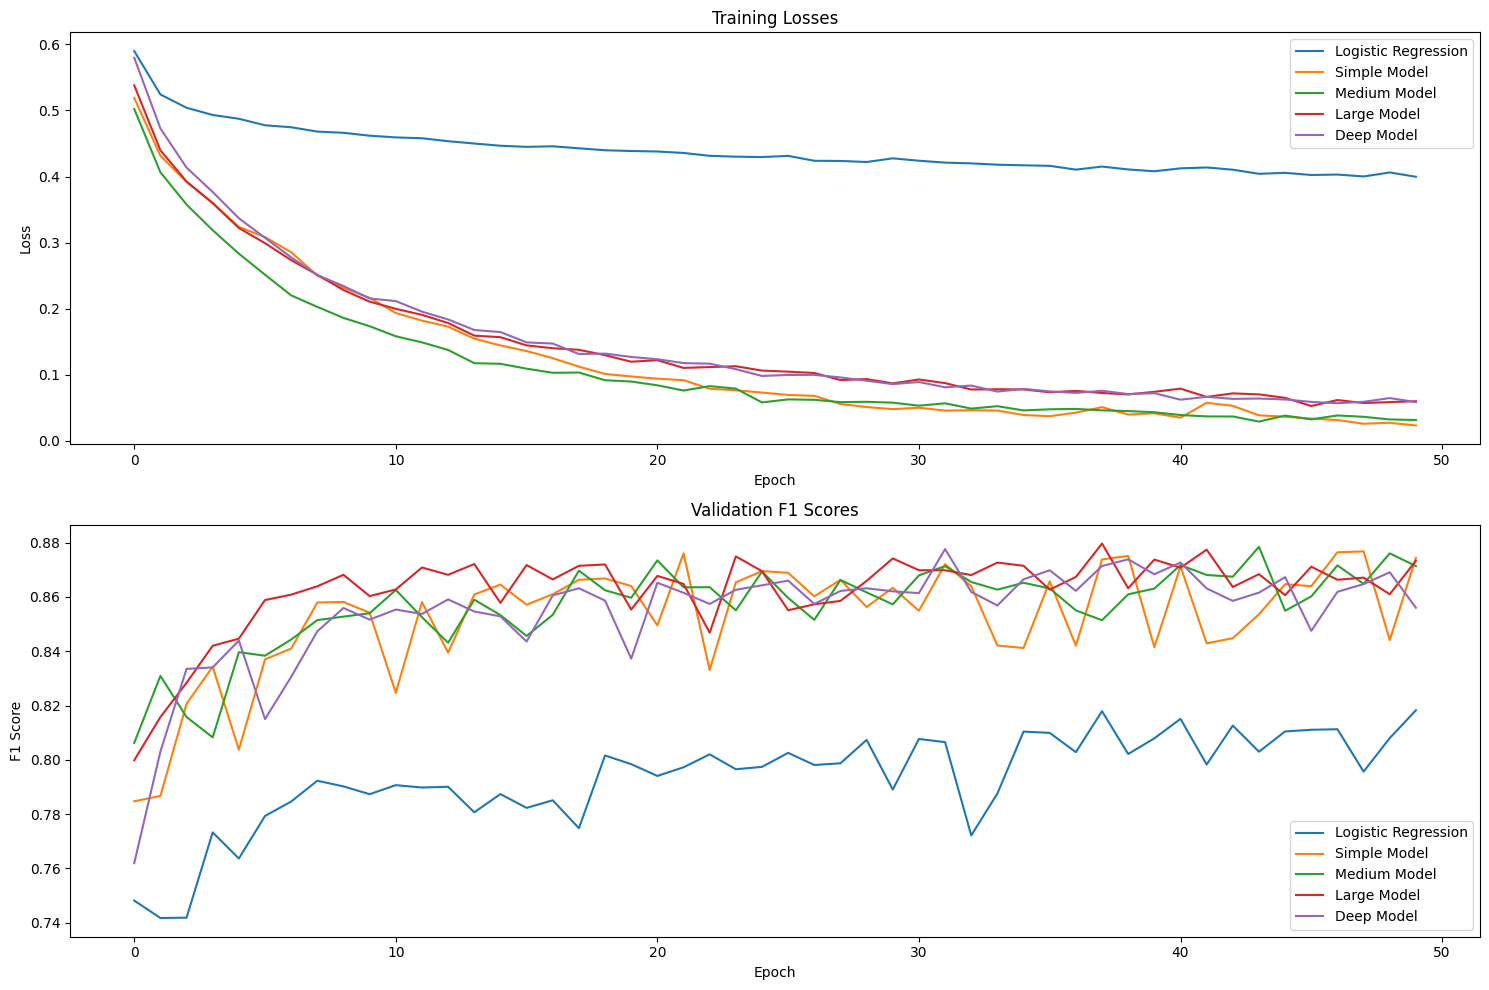


Model Comparison:
--------------------------------------------------------------------------------
Model                Accuracy   Precision  Recall     F1 Score  
--------------------------------------------------------------------------------
Logistic Regression  0.7901     0.7672     0.8445     0.8040
Simple Model         0.8542     0.8407     0.8810     0.8604
Medium Model         0.8606     0.8419     0.8944     0.8674
Large Model          0.8562     0.8369     0.8916     0.8634
Deep Model           0.8567     0.8697     0.8455     0.8574


In [7]:
# Model configurations with different parameters + hyperparameters (layers, dropout, learning rates, batch sizes, etc)
model_configs = [
    {
        "name": "Logistic Regression",
        "hidden_dims": [],
        "dropout_rates": [],
        "learning_rate": 0.001,
        "weight_decay": 0,
        "batch_size": 256
    },
    {
        "name": "Simple Model",
        "hidden_dims": [128],
        "dropout_rates": [0.1],
        "learning_rate": 0.001,
        "weight_decay": 0,
        "batch_size": 256
    },
    {
        "name": "Medium Model",
        "hidden_dims": [512, 256, 128],
        "dropout_rates": [0.2, 0.2, 0.1],
        "learning_rate": 0.0003,
        "weight_decay": 1e-5,
        "batch_size": 128
    },
    {
        "name": "Large Model",
        "hidden_dims": [1024, 512, 256, 128],
        "dropout_rates": [0.3, 0.3, 0.2, 0.1],
        "learning_rate": 0.0001,
        "weight_decay": 1e-5,
        "batch_size": 64
    },
    {
        "name": "Deep Model",
        "hidden_dims": [512, 256, 128, 64, 32],
        "dropout_rates": [0.2, 0.2, 0.2, 0.1, 0.1],
        "learning_rate": 0.0002,
        "weight_decay": 1e-5,
        "batch_size": 96
    }
]
class ProteinClassifier(nn.Module):
    def __init__(self, input_dim=3072, hidden_dims=[1024, 512, 256], dropout_rates=[0.2, 0.2, 0.1]):
        super().__init__()
        
        layers = []
        current_dim = input_dim
        
        for i, hidden_dim in enumerate(hidden_dims):
            layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rates[i])
            ])
            current_dim = hidden_dim
            
        # Output layer
        layers.extend([
            nn.Linear(current_dim, 1),
            nn.Sigmoid()
        ])
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x).squeeze()

def train_and_evaluate_model(config, n_epochs=50):
    print(f"\nTraining {config['name']}...")
    
    # Initialize model
    model = ProteinClassifier(
        hidden_dims=config['hidden_dims'],
        dropout_rates=config['dropout_rates']
    ).to(device)
    
    # Set up training
    criterion = nn.BCELoss()
    optimizer = optim.Adam(
        model.parameters(), 
        lr=config['learning_rate'], 
        weight_decay=config['weight_decay']
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
    
    train_losses = []
    val_metrics = []
    best_val_f1 = 0
    best_model = None
    
    for epoch in range(n_epochs):
        # Train
        model.train()
        total_loss = 0
        predictions = []
        true_labels = []
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Normalize inputs
            inputs = (inputs - inputs.mean(dim=1, keepdim=True)) / (inputs.std(dim=1, keepdim=True) + 1e-8)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            predictions.extend((outputs > 0.5).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Evaluate
        train_metrics = evaluate(model, train_loader)
        val_metrics_epoch = evaluate(model, val_loader)
        val_metrics.append(val_metrics_epoch)
        
        # Save best model to evaluate for the test set
        if val_metrics_epoch['f1'] > best_val_f1:
            best_val_f1 = val_metrics_epoch['f1']
            best_model = deepcopy(model.state_dict())
        
        if (epoch + 1) % 5 == 0:  # Print every 5 epochs
            print(f"\nEpoch {epoch+1}/{n_epochs}")
            print(f"Train Loss: {avg_loss:.4f}")
            print(f"Train Metrics: Accuracy={train_metrics['accuracy']:.4f}, F1={train_metrics['f1']:.4f}")
            print(f"Val Metrics: Accuracy={val_metrics_epoch['accuracy']:.4f}, F1={val_metrics_epoch['f1']:.4f}")
    
    # Load best model and evaluate on test set
    model.load_state_dict(best_model)
    test_metrics = evaluate(model, test_loader)
    
    return {
        'name': config['name'],
        'train_losses': train_losses,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'model': model
    }

def evaluate(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = (inputs - inputs.mean(dim=1, keepdim=True)) / (inputs.std(dim=1, keepdim=True) + 1e-8)
            outputs = model(inputs)
            predictions.extend((outputs > 0.5).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return {
        'accuracy': accuracy_score(true_labels, predictions),
        'precision': precision_score(true_labels, predictions, zero_division=0),
        'recall': recall_score(true_labels, predictions, zero_division=0),
        'f1': f1_score(true_labels, predictions, zero_division=0)
    }

# Train all models
results = []
for config in model_configs:
    result = train_and_evaluate_model(config)
    results.append(result)
    
    print(f"\n{result['name']} Final Test Metrics:")
    print(f"Accuracy: {result['test_metrics']['accuracy']:.4f}")
    print(f"Precision: {result['test_metrics']['precision']:.4f}")
    print(f"Recall: {result['test_metrics']['recall']:.4f}")
    print(f"F1 Score: {result['test_metrics']['f1']:.4f}")

# Plot results
plt.figure(figsize=(15, 10))

# Plot training losses
plt.subplot(2, 1, 1)
for result in results:
    plt.plot(result['train_losses'], label=result['name'])
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation F1 scores
plt.subplot(2, 1, 2)
for result in results:
    f1_scores = [m['f1'] for m in result['val_metrics']]
    plt.plot(f1_scores, label=result['name'])
plt.title('Validation F1 Scores')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

# Print comparison table
print("\nModel Comparison:")
print("-" * 80)
print(f"{'Model':20} {'Accuracy':10} {'Precision':10} {'Recall':10} {'F1 Score':10}")
print("-" * 80)
for result in results:
    metrics = result['test_metrics']
    print(f"{result['name']:20} "
          f"{metrics['accuracy']:.4f}     "
          f"{metrics['precision']:.4f}     "
          f"{metrics['recall']:.4f}     "
          f"{metrics['f1']:.4f}")